## Import required libraries

In [1]:
import numpy as np
import pandas as pd

### Load Dataset

In [2]:
krigging_dataset = pd.read_excel("jul2022.xlsx")
krigging_dataset.shape

(36, 2)

### Find latitude and longitude of each market in Dataset

In [3]:
from geopy.geocoders import Nominatim
def get_location(Market):
    geolocator = Nominatim(user_agent='india-api', timeout=10)
    location = geolocator.geocode(Market)
    if location:
        return [location.latitude, location.longitude]
    else:
        return [None, None]

#### Create latitude, longitude columns in dataset and update the values using the above function by sending market name as input

In [4]:
krigging_dataset.insert(2, "latitude", 0)
krigging_dataset.insert(3, "longitude", 0)

In [5]:
for row in krigging_dataset.itertuples():
    location=get_location(str(krigging_dataset.at[row.Index,'Market'])+', karnataka')
    krigging_dataset.at[row.Index,'latitude']=location[0]
    krigging_dataset.at[row.Index,'longitude']=location[1] 

##### Drop rows that have null values in the latitude and longitude section

In [6]:
krigging_dataset=krigging_dataset.dropna()


#### Perform grid search using GridSearchCV to find the best parameters for the Krige method from pykrige.rk and stores the best parameters.

In [7]:
from pykrige.rk import Krige
from sklearn.model_selection import GridSearchCV
import warnings
param_dict = {
    "method": ["ordinary"],
    "variogram_model": ["linear", "power", "gaussian", "spherical"],
    "nlags": [4, 6, 8, 12],
    "weight": [True, False]
}

estimator = GridSearchCV(Krige(), param_dict, verbose=0, return_train_score=True)
warnings.filterwarnings("ignore", message="n_closest_points will be ignored for UniversalKriging")
estimator.fit(X=krigging_dataset[['longitude', 'latitude']].values, y=krigging_dataset['Modal Price'].values)

if hasattr(estimator, 'best_score_'):
    print('best_score R² = {:.3f}'.format(estimator.best_score_))
    print('best_params = ', estimator.best_params_)
best_parameters=estimator.best_params_


best_score R² = -5.217
best_params =  {'method': 'ordinary', 'nlags': 4, 'variogram_model': 'linear', 'weight': False}


#### Read boundary shapefile using geopandas, performs Ordinary Kriging using pykrige.ok for the rectangle grid around the boundary and stores the interpolated values.

In [8]:
import geopandas as gpd
from pykrige.ok import OrdinaryKriging

boundary = gpd.read_file("karnataka.shp")
min_lon, min_lat, max_lon, max_lat = boundary.total_bounds
grid_lon = np.linspace(min_lon, max_lon, 300)
grid_lat = np.linspace(min_lat, max_lat, 300)

model = OrdinaryKriging(
    krigging_dataset['longitude'], krigging_dataset['latitude'],krigging_dataset['Modal Price'],
    variogram_model=best_parameters['variogram_model'],
    nlags=best_parameters['nlags'],
    weight=best_parameters['weight'],
    verbose=False)

z, ss = model.execute('grid', grid_lon, grid_lat)

C:\Users\sagar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\sagar\AppData\Local\Temp\ipykernel_14268\552951034.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working a

#### plot the clipped values(interpolated Modal Price) on a map over the shapefile boundary

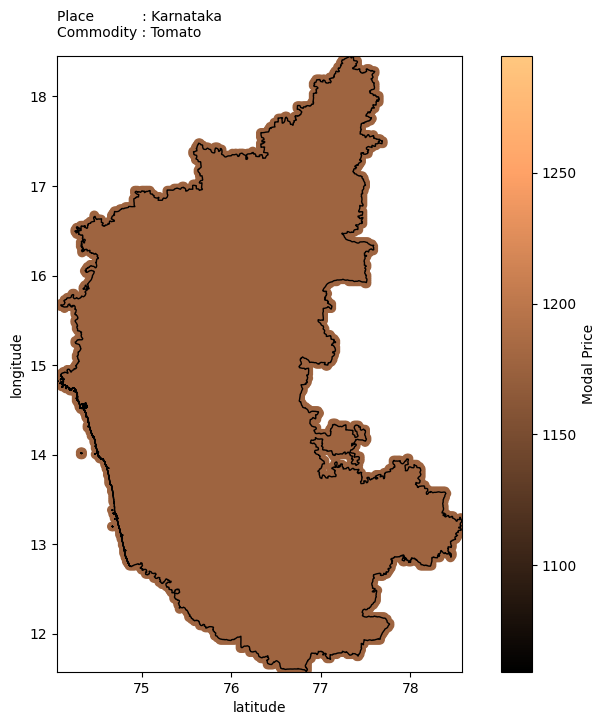

In [11]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from matplotlib.path import Path
from matplotlib.patches import PathPatch

boundary_poly = boundary.geometry.unary_union

clipped_values = []
clipped_lon = []
clipped_lat = []

for i in range(len(grid_lon) - 1):
    for j in range(len(grid_lat) - 1):
        poly = Polygon([
            (grid_lon[i], grid_lat[j]),
            (grid_lon[i + 1], grid_lat[j]),
            (grid_lon[i + 1], grid_lat[j + 1]),
            (grid_lon[i], grid_lat[j + 1])
        ])
        if poly.intersects(boundary_poly):
            clipped_values.append(z[j, i])
            clipped_lon.append((grid_lon[i] + grid_lon[i + 1]) / 2)
            clipped_lat.append((grid_lat[j] + grid_lat[j + 1]) / 2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.set_xlim(min_lon, max_lon)
ax.set_ylim(min_lat, max_lat)
im = ax.scatter(clipped_lon, clipped_lat, c=clipped_values, cmap='copper')
boundary.plot(ax=ax, edgecolor='black', facecolor='none')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Modal Price")
title_text = 'Place           : Karnataka \nCommodity : Tomato'
plt.text(0, 1.05, title_text, ha='left', va='center', transform=plt.gca().transAxes, fontsize=10, color='black')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()